#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 7
### Due: Monday, Mar 21th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 21th.

---

## Problem 1

**Fitting Data with MCMC**

Start with the code snipplet below to generate data.
Then, following the approach shown in `lecture_7.ipynb`, using either `emcee` or `pymc3`, fit a straight line to the data. Create the trace plots.

- Describe/ discuss where you should cut off burn-in. 
- Compute the autocorrelation length of the chain. 
- Using `corner`, make a corner plot that has labels, shows titles, and has $68\%$ and $95\%$ quantiles and levels. 








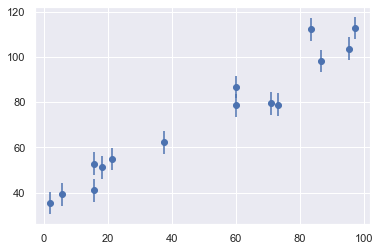

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

def make_data(intercept, slope, N=15, dy=5, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = (37, 0.75)
x, y, dy = make_data(*theta_true)

plt.errorbar(x, y, dy, fmt='o');


### Solution

In [2]:
#Import packages
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample
import statsmodels.api as sm
import corner

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#Model from PyMC3 documentation: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-linear.html
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    #Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)

    #Define likelihood
    likelihood = Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)

    #Inference
    #Draw posterior samples using NUTS sampling
    trace = sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\jtsen\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\jtsen\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
The acceptance probability does not match the target. It is 0.7118280366220551, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6824155277704803, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


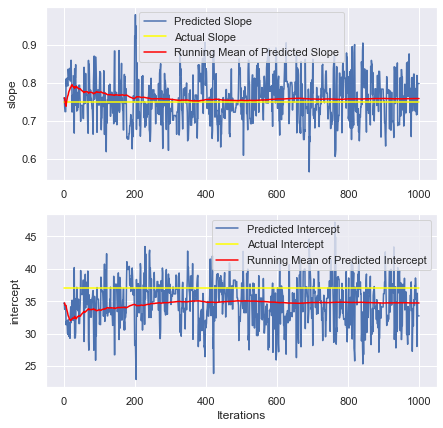

In [4]:
#Get trace values from MultiTrace object
slopePred = trace.posterior.x[0]
interceptPred = trace.posterior.Intercept[0]

#Get expected values 
interceptAct = theta_true[0]
slopeAct = theta_true[1]

#Get running average of trace values
slopeRunningMean = [np.mean(slopePred[:int(N)]) for N in range(np.size(slopePred))]
interceptRunningMean = [np.mean(interceptPred[:int(N)]) for N in range(np.size(interceptPred))]

#Plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(7,7)
plt.xlabel("Iterations")
ax1.plot(slopePred, label='Predicted Slope') 
ax1.plot(slopeAct*np.ones(len(slopePred)),c='yellow',label='Actual Slope')
ax1.plot(slopeRunningMean,c='red',label='Running Mean of Predicted Slope')
ax1.set_ylabel("slope")
ax1.legend()
ax2.plot(interceptPred, label='Predicted Intercept')
ax2.plot(interceptAct*np.ones(len(slopePred)), c='yellow', label='Actual Intercept')
ax2.plot(interceptRunningMean,c='red',label='Running Mean of Predicted Intercept')
ax2.set_ylabel("intercept")
ax2.legend()

This particular convergence started very close to the end values. Therefore, it would be hard to justify cutting out values. However, I would maybe cut off the first 200 iterations. After about 200 iterations there is a minimal change in the running mean of predicted values.

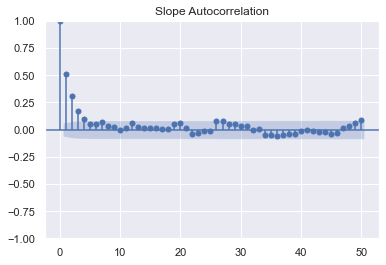

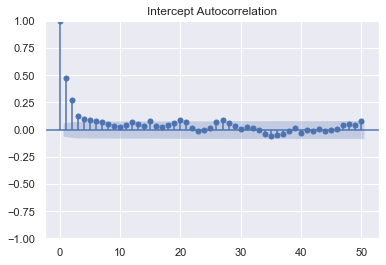

In [5]:
#Plot autocorrelation along length of chain using statsmodels
sm.graphics.tsa.plot_acf(slopePred.values.squeeze(), lags=round(50),title="Slope Autocorrelation")
sm.graphics.tsa.plot_acf(interceptPred.values.squeeze(), lags=round(50),title="Intercept Autocorrelation")
plt.show()

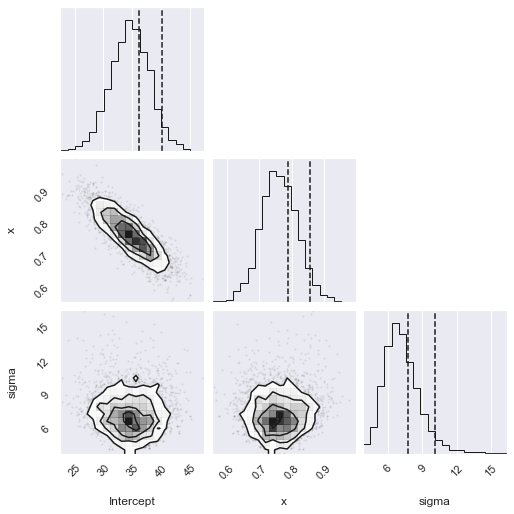

In [6]:
#Generate corner plot
assign = corner.corner(trace, quantiles=[0.68, 0.95])

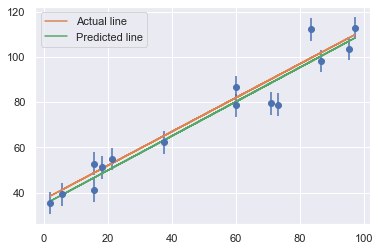

In [37]:
#Plot fit for comparison
plt.errorbar(x, y, dy, fmt='o');
plt.plot(x, slopeAct*x+interceptAct,'-', label='Actual line')
slopeAve = slopePred.mean().values
interceptAve = interceptPred.mean().values
plt.plot(x, slopeAve*x+interceptAve,'-', label='Predicted line')
plt.legend()